In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2024-07-20 14:32:08--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.008s  

2024-07-20 14:32:09 (336 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



# 라이브러리

In [ ]:
# 파이썬 표준 라이브러리
import string
import random

# 파이썬 서드파티 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# 클래스

## 위치 임베딩

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length: int, input_dim: int, output_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

## 인코더 레이어

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential(
            [layers.Dense(units=dense_dim, activation="swish", kernel_initializer="he_normal"),
             layers.Dense(units=embed_dim, activation="swish", kernel_initializer="he_normal")]
        )
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.dropout = layers.Dropout(rate=dropout_rate)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dropout(proj_output)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## 디코더 레이어

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential([
            layers.Dense(units=dense_dim, activation="swish", kernel_initializer="he_normal"),
            layers.Dense(units=embed_dim, activation="swish", kernel_initializer="he_normal")
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-7)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            use_causal_mask=True)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

# 함수

In [ ]:
# 텍스트 표준화 함수
def custom_standardization(input_string: str) -> str:
    """텍스트를 입력받아서 표준화하는 함수

    Args:
        input_string: 입력 데이터 -> str

    Returns:
        표준화 작업을 마친 텍스트 -> str
    """
    strip_chars = string.punctuation + "¿"
    strip_chars = strip_chars.replace("[", "")
    strip_chars = strip_chars.replace("]", "")
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

In [ ]:
# 영어와 스페인어 텍스트 리스트를 소스/타깃 데이터로 만드는 함수
def format_dataset(source_vectorization: layers.TextVectorization, target_vectorization: layers.TextVectorization):
    def source_target_dataset(eng: list[str], spa: list[str]) -> tuple[dict[str, np.array], np.array]:
        """영어와 스페인어 텍스트 리스트를 소스/타깃 데이터로 만드는 함수

        Args:
            eng: 영어 데이터 리스트 -> list[str]
            spa: 스페인어 데이터 리스트 -> list[str]

        Returns:
            소스 데이터와 타깃 데이터 -> tuple[dict[str, np.Array[Shape[None, None], dtype=int]],
                                                np.Array[Shape[None, None], dtype=int]]
        """
        eng = source_vectorization(eng)
        spa = target_vectorization(spa)
        return ({
            "english": eng,
            "spanish": spa[:, :-1],
        }, spa[:, 1:])
    return source_target_dataset

# 데이터셋 생성 함수
def make_dataset(pairs: list[tuple[str, str]],
                 source_vectorization: layers.TextVectorization,
                 target_vectorization: layers.TextVectorization) -> tf.data.Dataset:
    """영어와 스페인어 텍스트가 들어있는 리스트 tensorflow Dataset으로 변환하는 함수

    Args:
        pairs: 영어와 스페인어 텍스트가 튜플로 들어있는 리스트 -> list[tuple[str, str]]

    Returns:
        tensorflow Dataset
    """
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset(source_vectorization=source_vectorization, target_vectorization=target_vectorization), num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

In [ ]:
# 영어를 스페인어 텍스트로 번역하는 함수
def decode_sequence(input_sentence: str, max_decoded_sentence_length: int, spa_index_lookup: dict[int, str],
                    source_vectorization: layers.TextVectorization, target_vectorization: layers.TextVectorization,
                    model: keras.Model) -> str:
    """영어를 스페인어 텍스트로 번역하는 함수

    Args:
        input_sentence: 영어 텍스트 -> str
        max_decoded_sentence_length: 스페인어 문장 최대 길이 -> int
        spa_index_lookup: 인덱싱 딕셔너리 -> dict[int, str]
        source_vectorization: 영어를 인코딩하는 함수 -> layers.TextVectorization
        target_vectorization: 스페인어를 인코딩하는 함수 -> layers.TextVectorization
        model: 예측 모델 -> keras.Model

    Returns:
        스페인어 -> str
    """
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = model(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = int(np.argmax(predictions[0, i, :]))
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# 변수

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

# 데이터 불러오기 및 텍스트 벡터화

## 영어와 스페인어 텍스트 데이터 불러오기 및 데이터 분할

In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []

for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]" # 스페인어 문장의 앞과 뒤에 시작 토큰 및 종료 토큰 추가
    text_pairs.append((english, spanish))

In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

## 영어와 스페인어 텍스트 쌍을 벡터화

In [ ]:
vocab_size = 15000
sequence_length = 50

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

# 모델

## 데이터셋 생성

In [ ]:
batch_size = 64

train_ds = make_dataset(pairs=train_pairs, source_vectorization=source_vectorization, target_vectorization=target_vectorization)
val_ds = make_dataset(pairs=val_pairs, source_vectorization=source_vectorization, target_vectorization=target_vectorization)

## 모델 아키텍처

In [ ]:
embed_dim = 128
dense_dim = 1024
num_heads = 8
dropout_rate = 0.35

# 트랜스포머 인코더
encoder_inputs = keras.Input(shape=(None,), dtype="uint16", name="english")
x = PositionalEmbedding(sequence_length=sequence_length, input_dim=vocab_size, output_dim=embed_dim)(encoder_inputs)
x = EncoderLayer(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)(x)
encoder_outputs = EncoderLayer(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)(x)
# 트랜스포머 디코더
decoder_inputs = keras.Input(shape=(None,), dtype="uint16", name="spanish")
x = PositionalEmbedding(sequence_length=sequence_length, input_dim=vocab_size, output_dim=embed_dim)(decoder_inputs)
x = DecoderLayer(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)(x, encoder_outputs)
x = DecoderLayer(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)(x, encoder_outputs)
x = layers.Dropout(rate=0.5)(x)

decoder_outputs = layers.Dense(units=vocab_size, activation="softmax")(x)
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 positional_embedding_4 (Po  (None, None, 128)            1926400   ['english[0][0]']             
 sitionalEmbedding)                                                                               
                                                                                                  
 spanish (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 encoder_layer_4 (EncoderLa  (None, None, 128)            791296    ['positional_embedding_4

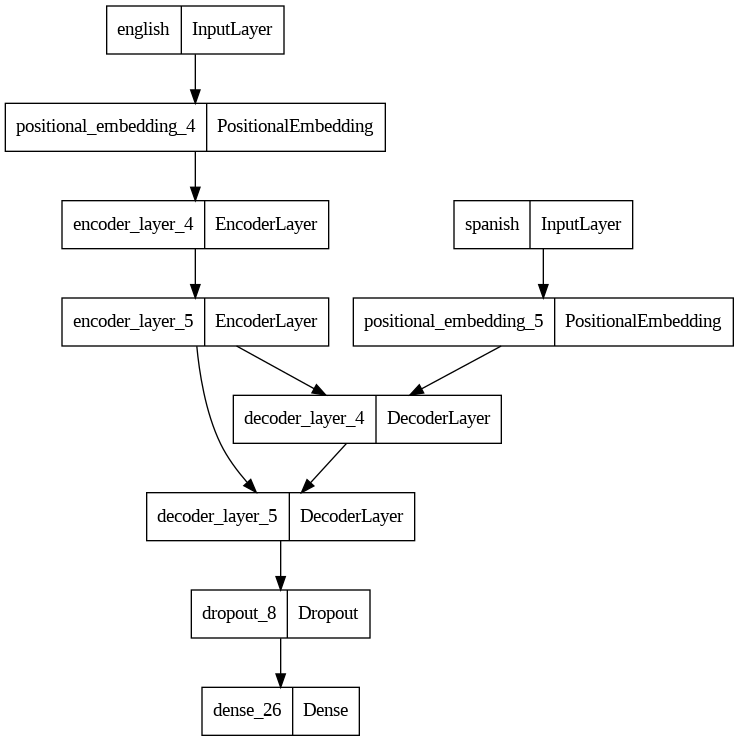

In [ ]:
plot_model(model)

## 모델 훈련

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(), metrics=["accuracy"])
history = model.fit(train_ds, epochs=15, shuffle=True, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 138s 91ms/step - loss: 4.2910 - accuracy: 0.3608 - val_loss: 3.2816 - val_accuracy: 0.4464
Epoch 2/15
1302/1302 [==============================] - 101s 78ms/step - loss: 3.0584 - accuracy: 0.5017 - val_loss: 2.3785 - val_accuracy: 0.5864
Epoch 3/15
1302/1302 [==============================] - 101s 78ms/step - loss: 2.3453 - accuracy: 0.6040 - val_loss: 1.9572 - val_accuracy: 0.6545
Epoch 4/15
1302/1302 [==============================] - 101s 78ms/step - loss: 1.9478 - accuracy: 0.6561 - val_loss: 1.7434 - val_accuracy: 0.6815
Epoch 5/15
1302/1302 [==============================] - 101s 78ms/step - loss: 1.7101 - accuracy: 0.6853 - val_loss: 1.6653 - val_accuracy: 0.6928
Epoch 6/15
1302/1302 [==============================] - 101s 78ms/step - loss: 1.5440 - accuracy: 0.7064 - val_loss: 1.5855 - val_accuracy: 0.7054
Epoch 7/15
1302/1302 [==============================] - 101s 78ms/step - loss: 1.4206 - accuracy: 0.7223 - val_loss: 1

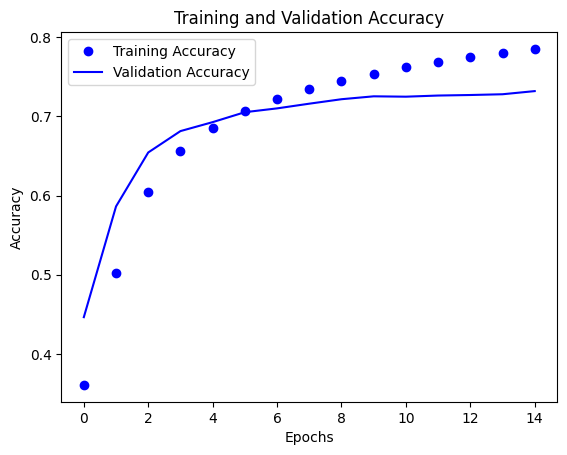

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(len(acc)), acc, "bo", label="Training Accuracy")
plt.plot(range(len(val_acc)), val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

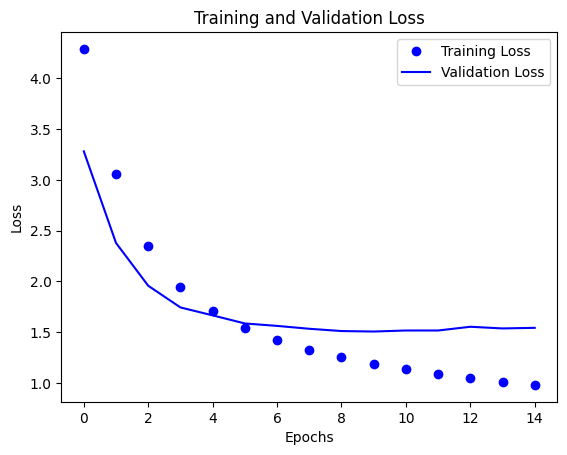

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(range(len(loss)), loss, "bo", label="Training Loss")
plt.plot(range(len(val_loss)), val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 번역

In [ ]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = sequence_length

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence=input_sentence, max_decoded_sentence_length=max_decoded_sentence_length, spa_index_lookup=spa_index_lookup,
                          source_vectorization=source_vectorization, target_vectorization=target_vectorization, model=model))

-
He has recovered his health, so he is now able to resume his studies.
[start] Él se recuperó su salud así que ahora es capaz de mantenerse estudiando [end]
-
We believe that it was Tom that killed Mary.
[start] creemos que fue tom que mataron a mary [end]
-
Tom doesn't want to work in a factory.
[start] tom no quiere trabajar en una fábrica [end]
-
The monkey is in the cage.
[start] el mono está en la jaula [end]
-
There is a pen between the apple and the book.
[start] hay un bolígrafo entre la manzana y el libro [end]
-
It's unbearably hot.
[start] hace calor caliente [end]
-
It must've been very difficult for you.
[start] tiene que haber sido muy difícil para ti [end]
-
Did he stay very long?
[start] Él se ha estado muy largo tiempo [end]
-
It wasn't important.
[start] no fue importante [end]
-
I'm doing well today.
[start] hoy estoy haciendo bien [end]
-
Tom and Mary both work for me.
[start] tom y mary trabajan por mí [end]
-
Do we need to wait for her?
[start] necesitamos que es